# Preliminaries and Imports

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# system and path set up
import os
import sys

# path
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', 'ColabNotebooks', 'DL','Deep Learning Project Full','DL Team Project', '20251126_22.47_DL_Team_Project_Code_Files_Structure')

# set working directory (for saving/ loading)
os.chdir(GOOGLE_DRIVE_PATH)

# set import path (for importing src/)
sys.path.insert(0, GOOGLE_DRIVE_PATH)

# verify
print("Current working directory:", os.getcwd())
print("Current import directory:", sys.path[0])


Current working directory: /content/drive/My Drive/ColabNotebooks/DL/Deep Learning Project Full/DL Team Project/20251126_22.47_DL_Team_Project_Code_Files_Structure
Current import directory: /content/drive/My Drive/ColabNotebooks/DL/Deep Learning Project Full/DL Team Project/20251126_22.47_DL_Team_Project_Code_Files_Structure


In [ ]:
# log into HF
# note: previously store your key as secret (key symbol on the left)
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

from huggingface_hub import login
login(token=hf_token)

# Option: silence all HF logs
from transformers.utils.logging import set_verbosity_error
set_verbosity_error()

In [ ]:
# install libraries (only once and then comment out)
!pip install -q "transformers>=4.40.0" accelerate datasets peft bitsandbytes trl
!pip install -q -U bitsandbytes transformers accelerate peft trl

In [ ]:
# import standard libraries
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from peft import LoraConfig

# import utils
from src import utils

# import model
from src.model_llama_lora import CommonMethods, LlamaBaseModel, LlamaLoraModel

# create instance object of CommonMethods
cm = CommonMethods()

In [ ]:
# set seed for reproduceibility (Note: does not work for OpenAI)
seed = 42

# Load and prepare data

In [ ]:
# load pre-processed data
csv_path_train_data = f"{GOOGLE_DRIVE_PATH}/data/data_train.csv"
csv_path_val_data = f"{GOOGLE_DRIVE_PATH}/data/data_val.csv"
csv_path_test_data = f"{GOOGLE_DRIVE_PATH}/data/data_test.csv"

train_bal = pd.read_csv(csv_path_train_data)
val = pd.read_csv(csv_path_val_data)
test = pd.read_csv(csv_path_test_data)

In [ ]:
# keep only needed columns (drop lang and label5)
train_bal = train_bal.drop(columns=["label5","lang"])
val = val.drop(columns=["label5","lang"])
test = test.drop(columns=["label5","lang"])

In [ ]:
# downsample data
# Note: Fine-tuning on full data would take too long
train_bal = train_bal.sample(n=2000, random_state=seed)
val = val.sample(n=2000, random_state=seed)
test = test.sample(n=2000, random_state=seed)

# Run model/ Experiment

Specify model:
- Choose model type
- quant_config
- Instruction

Specify data for evaluation:
- val data: for tuning
- test data: for final run

In [ ]:
# choose model
model_name = "meta-llama/Llama-3.2-3B-Instruct" # "meta-llama/Meta-Llama-3-8B-Instruct"

In [ ]:
# set quantification configuration
quant_config = BitsAndBytesConfig(
    load_in_4_bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16)

In [ ]:
# instruction
instruction = "Classify the following product review into one of: negative, neutral, positive."

In [ ]:
# set x and y variables for evaluation
# Note: Does not affect train (uses always train data and val data) but only evaluation metrics
x = val["text"] # choose from: val["text"], test["text"]
y = val["label3"] # choose from: val["label3"], test["label3"]

In [ ]:
# create instance of model
model_llama_base = LlamaBaseModel(model_name, quant_config, instruction)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# predict with model (measuring time)
t0 = time.perf_counter()

pred_txt = model_llama_base.predict(
    x=x,
    text_token_limit=256,
    report_interval=100)

pred_num = cm.label3_txt_to_num(pred_txt)

t1 = time.perf_counter()

Reviews processed: 100
Reviews processed: 200
Reviews processed: 300
Reviews processed: 400
Reviews processed: 500
Reviews processed: 600
Reviews processed: 700
Reviews processed: 800
Reviews processed: 900
Reviews processed: 1000
Reviews processed: 1100
Reviews processed: 1200
Reviews processed: 1300
Reviews processed: 1400
Reviews processed: 1500
Reviews processed: 1600
Reviews processed: 1700
Reviews processed: 1800
Reviews processed: 1900
Reviews processed: 2000


In [ ]:
# sanity check: accuracy
acc = sum(y == pred_num) / len(pred_num)
print(f"acc cntrl: {acc}")

acc cntrl: 0.1355


In [ ]:
# create a run directory (analogous to KP)
hyperparams = {
    "learning_rate": "NA",
    "train_batch_size": "NA",
    "epochs": "NA" }

run_outdir = utils.make_run_dir(
    output_root="outputs",
    model_name=f"{model_name}_base_zeroshot",
    hyperparams=hyperparams)

print("run_outdir:", run_outdir)

run_outdir: outputs/meta-llama_Llama-3.2-3B-Instruct_base_zeroshot_lrNA_bsNA_epNA_20251205_085552


# Evaluate Results/ Experiment



In [ ]:
# classification metrics (incl. saving classification report as csv)
metrics = utils.compute_classification_metrics_from_arrays(y_true=y, y_pred=pred_num)
df_cfreport = pd.DataFrame(metrics["classification report"]).T
print(df_cfreport)
path = os.path.join(run_outdir, "classification_report.csv")
df_cfreport.to_csv(path)

              precision    recall  f1-score    support
0              0.333333  0.251748  0.286853   429.0000
1              0.080802  0.836478  0.147368   159.0000
2              1.000000  0.021246  0.041609  1412.0000
accuracy       0.135500  0.135500  0.135500     0.1355
macro avg      0.471378  0.369824  0.158610  2000.0000
weighted avg   0.783924  0.135500  0.102622  2000.0000


<Figure size 600x600 with 0 Axes>

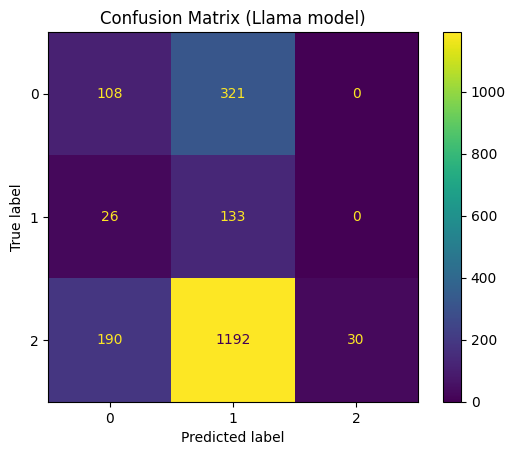

In [ ]:
# confusion matrix (incl. saving)
cm = confusion_matrix(y_true=y, y_pred=pred_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix (Llama model)")
path = os.path.join(run_outdir, "confusion_matrix.png")
plt.savefig(path, bbox_inches='tight')
plt.show()

In [ ]:
# evaluate time
pred_time_seconds = t1 - t0
pred_time_per_sample = pred_time_seconds / len(pred_num)
print("Prediction time in seconds:", pred_time_seconds)
print("Prediction time per sample:", pred_time_per_sample)

Prediction time in seconds: 516.1601605130004
Prediction time per sample: 0.2580800802565002


In [ ]:
# saving results in team_comparison_results
results_comparison = {
    "n_samples": len(x),
    "train_seconds": None,
    "pred_time_seconds": pred_time_seconds,
    "pred_time_per_sample": pred_time_per_sample,
    "metrics": metrics}

utils.save_results_csv(
    results=results_comparison,
    csv_path=os.path.join("outputs", "team_comparison_results.csv"),
    model_name=f"{model_name}_zeroshot",
    extra_info={"run_outdir": run_outdir})

Appended results to outputs/team_comparison_results.csv


In [ ]:
# saving all results in dictionary
results_all = results_comparison
results_all["model"] = f"{model_name}_zeroshot",
results_all["instruction"] = instruction
path = os.path.join(run_outdir, "results_all.json")
with open(path, "w") as f:
    json.dump(results_all, f, indent=2)
